In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool

from pydantic import BaseModel, Field
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os, sys, subprocess
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)


from langgraph.graph.message import add_messages 

#import pandas as pd

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Property(BaseModel):
    address: str = Field(description="The address of the property")
    date: str = Field(description="The date the property was sold")
    price: str = Field(description="The price of the property")

class PropertyList(BaseModel):
    properties: list[Property] = Field(description="A list of properties sold")

In [ ]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)

property_model = llm.with_structured_output(PropertyList)


# STATE
class TestingState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None

# TOOLS
#import contextlib
#import io
#import playwright
import sys
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """
    Execute the Python code and returns the output or error message.
    The playwright library is available for web interactions.
    You must use the playwright async library as this runs in Jupyter
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=os.environ.copy(),
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")


# NODES
def execute_code_node(state: TestingState) -> dict:
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

# GRAPH
graph = StateGraph(TestingState)
graph.add_node("code", execute_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
graph.add_edge("execute", "code")

web_testing_graph = graph.compile()


E0000 00:00:1765978540.966961   14526 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


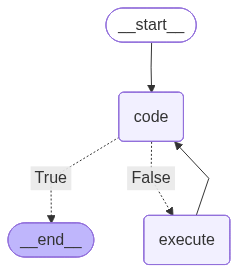

In [9]:
web_testing_graph

In [10]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer and web tester.
You have access to the playwright library to interact with web pages.
You can use the 'execute_code' tool to run Playwright scripts to read, navigate and enter data.
Use a user-agent in the playwright code such as : "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36"
Use playwright page.wait_for_load_state('networkidle') to ensure the page is fully loaded before interacting with it.
"""
instruction_message = """
You are required to test the following website: https://www.propertypriceregister.ie/website/npsra/pprweb.nsf/PPR?OpenForm .  This website is a registry of property prices in Ireland which can be searched by various criteria.
You must follow the steps below. Execute a playwright script, that caters for javascript enabled webpage, for each step until all steps are complete:
1. Navigate to the web page 
2. Wait for at least 5 seconds and read its content.
3. Identify the Address, County and Year Form Inputs and the perform search button.
4. Enter {address} as the Address, {county} as the County and {year} as the Year and submit the search form using the 'Perform Search'.A new page will open when the search is performed.
5. Wait for the Search Results to load. The Search Results will be in a table with id 'searchResultsTbl' Extract the results from the search results page and confirm that there are results for '{address}' in '{county}' for the year '{year}'.

Final Output:
- Return the number of results found and the first five entries including Address, County, Price and Date of Sale.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(address="Belmont", county="Dublin", year="2024")) ]

In [11]:
result = web_testing_graph.invoke(TestingState(messages=messages))
print(result['messages'][-1].content)

The search returned several results for 'Belmont' in 'Dublin' for the year '2024'.

Here are the details of the first five entries:

1.  **Date of Sale:** 04/11/2024, **Price:** €387,000.00, **Address:** 28 BELMONT SQ, RAHENY, DUBLIN 5, Dublin 5, D05TW13, **County:** Dublin
2.  **Date of Sale:** 14/10/2024, **Price:** €1,360,000.00, **Address:** 51 BELMONT AVE, DONNYBROOK, DUBLIN 4, Dublin 4, D04V6Y4, **County:** Dublin
3.  **Date of Sale:** 08/10/2024, **Price:** €80,000.00, **Address:** 167 BELMONT PARK, RAHENY, DUBLIN 5, Dublin 5, D05HP08, **County:** Dublin
4.  **Date of Sale:** 19/09/2024, **Price:** €255,000.00, **Address:** 6 BELMONT COURT, PHILIPSBURGH AVENUE, DUBLIN 3, D03E2W6, **County:** Dublin
5.  **Date of Sale:** 19/09/2024, **Price:** €327,000.00, **Address:** APT 7 BELMONT COURT, 8 PHILLIPSBURGH AVENUE, FAIRVIEW, D03W542, **County:** Dublin

A total of 25 results were found for 'Belmont' in 'Dublin' for the year '2024'.


In [3]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)

property_model = llm.with_structured_output(PropertyList)


# STATE
class PropertyState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None


E0000 00:00:1765985157.909566    4741 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
# TOOLS
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """
    Execute the Python code and returns the output or error message.
    The playwright library is available for web interactions.
    You must use the playwright async library as this runs in Jupyter
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=os.environ.copy(),
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")

In [ ]:
# NODES
def gen_playwright_code(state: PropertyState) -> dict:
    
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

def structured_output_node(state: PropertyState) -> dict:
    # Use the property_model to parse the latest AI message content
    ai_message = state.messages[-1]
    if not isinstance(ai_message, AIMessage):
        raise ValueError("The last message is not an AIMessage.")
    
    properties = property_model.parse(ai_message.content)
    return {"messages": state.messages, "properties": properties}


# GRAPH
graph = StateGraph(PropertyState)
graph.add_node("gen_code", gen_playwright_code)
graph.add_node("execute", ToolNode(tools=[execute_code]))
graph.add_node("structure_output", structured_output_node)

graph.add_edge(START, "gen_code")
graph.add_conditional_edges("gen_code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: "structure_output", False: "execute"})
graph.add_edge("execute", "gen_code")
graph.add_edge("structure_output", END)

web_testing_graph = graph.compile()



web_testing_graph = graph.compile()

In [8]:
web_testing_graph

ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer and web tester.
You have access to the playwright library to interact with web pages.
You can use the 'execute_code' tool to run Playwright scripts to read, navigate and enter data.
Use a user-agent in the playwright code such as : "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36"
Use playwright page.wait_for_load_state('networkidle') to ensure the page is fully loaded before interacting with it.
"""
instruction_message = """
You are required to test the following website: https://www.propertypriceregister.ie/website/npsra/pprweb.nsf/PPR?OpenForm .  This website is a registry of property prices in Ireland which can be searched by various criteria.
You must follow the steps below. Execute a playwright script, that caters for javascript enabled webpage, for each step until all steps are complete:
1. Navigate to the web page 
2. Wait for at least 5 seconds and read its content.
3. Identify the Address, County and Year Form Inputs and the perform search button.
4. Enter {address} as the Address, {county} as the County and {year} as the Year and submit the search form using the 'Perform Search'.A new page will open when the search is performed.
5. Wait for the Search Results to load. The Search Results will be in a table with id 'searchResultsTbl' Extract the results from the search results page and confirm that there are results for '{address}' in '{county}' for the year '{year}'.

Final Output:
- Return the number of results found and the first five entries including Address, County, Price and Date of Sale.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(address="Belmont", county="Dublin", year="2024")) ]